In [1]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 6.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# image libraries
import cv2

D1104 12:39:48.215826985      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1104 12:39:48.215852299      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1104 12:39:48.215856473      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1104 12:39:48.215859473      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1104 12:39:48.215862158      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1104 12:39:48.215865137      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1104 12:39:48.215870380      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1104 12:39:48.

In [3]:
train_img_path = '/kaggle/input/aidata/train'
test_img_path = '/kaggle/input/aidata/val'

w,h = 224,224
batch_size = 32

train_data_gen = ImageDataGenerator(
    rescale = 1.0/255
)
test_data_gen = ImageDataGenerator(rescale = 1.0/255)

train_Dataset = train_data_gen.flow_from_directory(
    train_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

test_Dataset = test_data_gen.flow_from_directory(
    test_img_path,
    target_size = (w,h),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False
)

Found 18557 images belonging to 2 classes.
Found 61 images belonging to 2 classes.


In [4]:
test_Dataset.class_indices


{'0': 0, '1': 1}

In [5]:
test_Dataset.image_shape

(224, 224, 3)

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.OneDeviceStrategy("GPU:0")  # Default strategy for non-TPU environments


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [7]:
# Load the MobileNetV2 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Use a valid input shape

# Create a new model by adding your custom top layers for binary classification
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Freeze the weights of the MobileNetV2 layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 22,327,585
Trainable params: 524,801
Non-tr

In [8]:
# Save best model
weight_path = '/kaggle/working/'

model_checkpoint = ModelCheckpoint(
    filepath = weight_path,
    save_best_only = True,
    save_weights_only = True,
    mode = 'max',
    monitor = 'val_accuracy'
)


In [10]:

num_folds = 5  # You can adjust this value based on your requirements

# Create a K-fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store the training and validation scores
train_scores = []
val_scores = []

# Convert the ImageDataGenerator to NumPy arrays
train_data = train_Dataset[0][0]
train_labels = train_Dataset[0][1]

for i in range(1, len(train_Dataset)):
    train_data = np.vstack((train_data, train_Dataset[i][0]))
    train_labels = np.hstack((train_labels, train_Dataset[i][1]))

for train_index, val_index in kf.split(train_data):
    train_subset_data = train_data[train_index]
    train_subset_labels = train_labels[train_index]
    val_subset_data = train_data[val_index]
    val_subset_labels = train_labels[val_index]

    # Create a new model for each fold (if needed) or reset the existing model

    # Fit the model to the current training fold
    history = model.fit(train_subset_data,
                        train_subset_labels,
                        epochs=8,
                        validation_data=(val_subset_data, val_subset_labels),
                        callbacks=[model_checkpoint]
                       )
    
    # Record the training and validation scores for this fold
    train_scores.append(history.history['accuracy'])
    val_scores.append(history.history['val_accuracy'])

# Calculate and report the average and standard deviation of the validation scores
average_val_score = np.mean(val_scores)
std_val_score = np.std(val_scores)

print("Average Validation Accuracy:", average_val_score)
print("Standard Deviation of Validation Accuracy:", std_val_score)


Epoch 1/8
464/464 [==============================] - 131s 272ms/step - loss: 0.4636 - accuracy: 0.7805 - val_loss: 0.3806 - val_accuracy: 0.8265
Epoch 2/8
464/464 [==============================] - 119s 257ms/step - loss: 0.3688 - accuracy: 0.8397 - val_loss: 0.3602 - val_accuracy: 0.8281
Epoch 3/8
464/464 [==============================] - 118s 254ms/step - loss: 0.3389 - accuracy: 0.8546 - val_loss: 0.3531 - val_accuracy: 0.8322
Epoch 4/8
464/464 [==============================] - 116s 251ms/step - loss: 0.3151 - accuracy: 0.8665 - val_loss: 0.3470 - val_accuracy: 0.8394
Epoch 5/8
464/464 [==============================] - 117s 251ms/step - loss: 0.3021 - accuracy: 0.8714 - val_loss: 0.3419 - val_accuracy: 0.8378
Epoch 6/8
464/464 [==============================] - 118s 255ms/step - loss: 0.2901 - accuracy: 0.8769 - val_loss: 0.3361 - val_accuracy: 0.8424
Epoch 7/8
464/464 [==============================] - 118s 255ms/step - loss: 0.2695 - accuracy: 0.8876 - val_loss: 0.3387 - val_ac

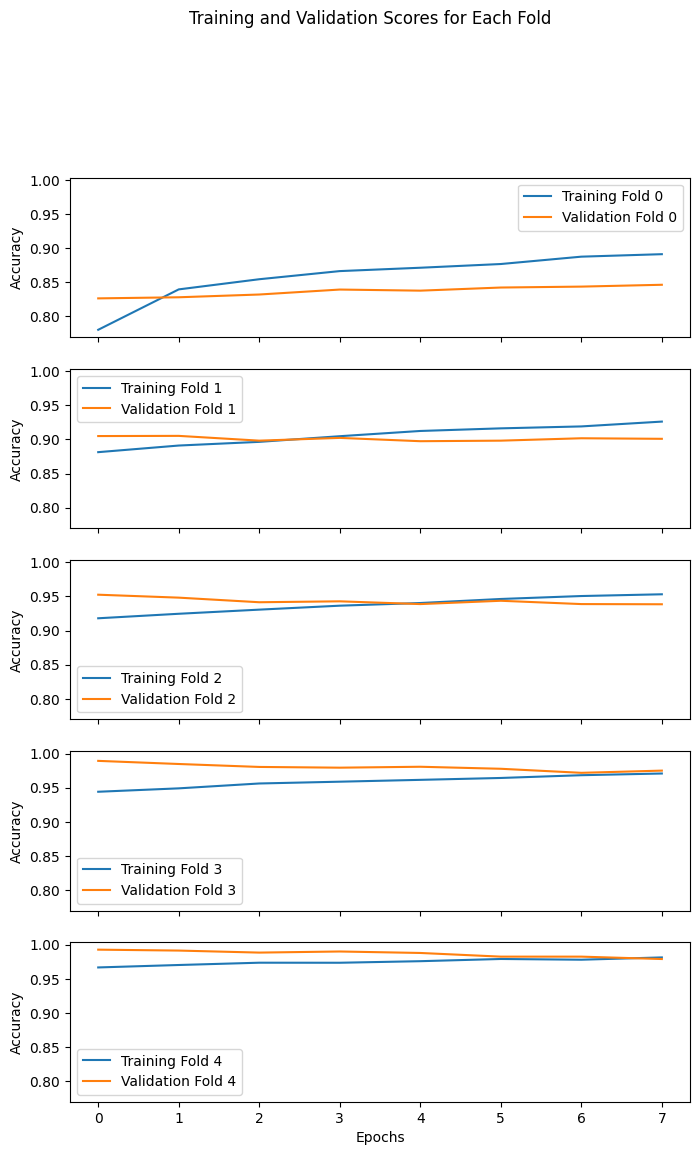

In [17]:
fig, axes = plt.subplots(num_folds, 1, figsize=(8, 12), sharex=True, sharey=True)

for i in range(num_folds):
    axes[i].plot(history.epoch, train_scores[i], label=f'Training Fold {i}')
    axes[i].plot(history.epoch, val_scores[i], label=f'Validation Fold {i}')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

# Set common labels and title
axes[-1].set_xlabel('Epochs')
fig.suptitle('Training and Validation Scores for Each Fold', y=1.02)

plt.show()

In [19]:
# load best weights to model
#model.load_weights(weight_path)

# make prediction
predictions = model.predict(test_Dataset)

2/2 [==============================] - 1s 156ms/step


In [20]:
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

              precision    recall  f1-score   support

           0       0.89      0.78      0.83        32
           1       0.79      0.90      0.84        29

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



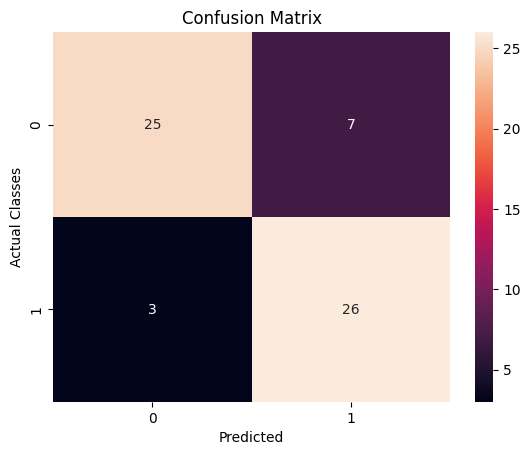

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have true labels (ground truth)
true_labels = test_Dataset.classes

# Generate a confusion matrix
sns.heatmap(confusion_matrix(true_labels, binary_predictions), annot=True)

# Print classification report
print(classification_report(true_labels, binary_predictions))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()

In [14]:
model.save('gnet.h5')

In [22]:
model.save('gnel.pkl')

INFO:tensorflow:Assets written to: gnel.pkl/assets


INFO:tensorflow:Assets written to: gnel.pkl/assets


In [23]:
import joblib
joblib.dump(model, 'model.joblib')


['model.joblib']